## Integration of Spatial Patterns and Machine Learning for Cholera Risk Assessment in Southern Ethiopia (PART 1)

### Abstract

This notebook zeroes in on cholera case data from Gedeo Zone, Ethiopia, during 2023. Using individual-level epidemiological and clinical records, my objective is to explore data patterns and develop a predictive model that can classify cholera severity based on dehydration status. By leveraging machine learning techniques, I aim to provide a tool that supports healthcare practitioners in making timely and accurate clinical decisions for cholera diagnosis and management based on readily observable indicators such as dehydration severity. This notebook demonstrates exploratory data analysis (EDA), feature engineering, and a baseline model setup to facilitate improved disease surveillance and targeted intervention. 



To streamline the workflow, this analysis is organized into **two** separate notebooks. The first notebook (this one!) focuses on exploratory data analysis (EDA), including descriptive statistics, visualizations of key variables, and spatial mapping of cholera cases alongside relevant environmental features. This foundation provides valuable insights into the data characteristics and geographic context. The second notebook will be dedicated to the machine learning modeling component, where predictive algorithms will be developed and evaluated to identify factors associated with cholera severity.


### Introduction

Cholera is an acute diarrheal infection caused by the bacterium *Vibrio cholerae*, which remains a major public health challenge in many low- and middle-income countries. Transmitted primarily through contaminated water and poor sanitation, cholera can cause rapid and severe dehydration, leading to death if untreated. Diagnosis typically relies on clinical signs, laboratory confirmation, and patient history. Treatment centers on prompt rehydration using oral or intravenous fluids and antibiotics in severe cases.

Dehydration status is widely recognized as the most critical clinical indicator of cholera severity, guiding treatment decisions and healthcare resource allocation. Identifying patients at risk of severe dehydration can drastically improve outcomes by ensuring timely and appropriate care.

Ethiopia, with its diverse geography and varying healthcare access, experiences recurrent cholera outbreaks. This study focuses on Gedeo Zone, an area located in the Southern Nations, Nationalities, and Peoples' Region (SNNPR) of Ethiopia. This is a predominantly rural, highland area known for smallholder agriculture and coffee production. Its hilly terrain and network of rivers provide vital resources but also contribute to challenges in water sanitation. Limited access to clean water and inadequate sanitation infrastructure make Gedeo prone to waterborne diseases such as cholera. This area has encountered a cholera outbreak in 2023 [[1]](https://www.unocha.org/publications/report/ethiopia/ethiopia-cholera-outbreak-flash-update-8-20-june-2023). Understanding patterns in individual case data alongside geographic trends is important for local disease control efforts.

## Data Description

This analysis uses **two primary datasets** capturing the cholera outbreak in Gedeo Zone, Ethiopia, during 2023. Both datasets were sourced from [[2]](https://data.mendeley.com/datasets/7zz3tp5kt5/1).

---

### CHOLERA1: Individual-level cholera case records

This dataset contains detailed case-based information for cholera patients, including:

| Column                       | Description / Use                                                                                      |
| ---------------------------- | ---------------------------------------------------------------------------------------------------- |
| `SerialNo`                   | Unique identifier for each patient record                                                            |
| `AgeYear`                   | Patient age in years                                                                                   |
| `Kebelename`                | Name of kebele (the smallest administrative unit in Ethiopia) where the patient resides               |
| `HealthFacilityCTC`         | Health facility where case was seen                                                                   |
| `DateseenathealthfacilityM` | Date patient was seen/admitted at the health facility                                                 |
| `DateofonsetofdiseaseMMD`   | Date of symptom onset                                                                                 |
| `Dischargedate`             | Date of discharge from care                                                                           |
| `Dehaydration_status`       | Dehydration severity (none, some, severe) – key clinical indicator                                    |
| `Hospitalized`              | Whether patient was hospitalized (yes/no)                                                             |
| `sex`                      | Patient sex                                                                                          |
| `Region`, `Zone`, `District`| Administrative divisions for geographic context                                                     |
| `symptom`, `diarrhoea`, `vomit` | Presence of key symptoms                                                                          |
| `Occupation`                | Patient occupation                                                                                    |
| `water`, `Water_source`     | Source of drinking water                                                                              |
| `Contact_history`, `Travel_history` | Risk factor indicators: recent contact or travel                                             |
| `outcome`                  | Case outcome status (recovered, died, referred, etc.)                                                 |
| `Vaccination`              | Cholera vaccination status (yes/no/unknown)                                                          |
| `Latrine_avalability`      | Whether latrine was available at patient’s household                                                  |

The dataset provides a rich combination of demographic, clinical, behavioral, and environmental factors at the case level, facilitating detailed epidemiological analysis and modeling.

---

### CHOLERA2: Kebele-level cholera summary with geo information

This dataset aggregates cholera data at the kebele level and includes:

| Column       | Description / Use                                                              |
| ------------ | ----------------------------------------------------------------------------- |
| `Locatio_ID` | Unique numeric code for kebele                                                |
| `Kebeles`    | Name of the kebele (should align with `Kebelename` in CHOLERA1 for linking)   |
| `Cases`      | Number of cholera cases reported in that kebele                              |
| `Population` | Estimated kebele population size                                              |
| `Incidence`  | Incidence rate (cases per unit population, often per 100,000 population)      |
| `Longitude`  | Geographic coordinate (longitude) for spatial mapping                         |
| `Latitude`   | Geographic coordinate (latitude) for spatial mapping                          |

This dataset is useful for spatial visualization, geographic clustering, and understanding disease burden relative to population size, enhancing epidemiological context.

---

### Data structure takeaways

- The mapping between `Kebelename` in CHOLERA1 and `Kebeles` in CHOLERA2 allows linking individual cases to spatial and population-level data.
- While CHOLERA1 requires cleaning for text standardization and missing values, CHOLERA2 is well-structured and primarily serves as reference spatial data.
- Temporal data present in CHOLERA1 (dates of onset, admission, discharge) allow temporal trend analysis.
- Clinical variables such as `Dehaydration_status` are critical for disease severity classification.
- Water and sanitation variables provide insight into possible environmental drivers and risk exposures.
- Some column names and elements may have been misspelled, but these were retained in this notebook



In [2]:
# LOAD DATASETS

# CHOLERA1
import pandas as pd
import numpy as np
fname = 'Final data.csv'
df_cholera = pd.read_csv(fname)

# CHOLERA2
df_gis = pd.read_excel('GIS_drop.xlsx')
print(df_cholera.head(2), df_gis.head(2))

   SerialNo  AgeYear      Kebelename  ... symptom diarrhoea vomit
0       368        1         Ononcho  ...       1         0     0
1       529        1  Michele sisota  ...       0         0     1

[2 rows x 38 columns]    Locatio_ID           Kebeles  Cases  ...  Incidence  Longitude  Latitude
0          18       Wonago Town     11  ...  58.519977  38.260923  6.319754
1          19  Yirgachefe Town       4  ...  11.923925  38.204145  6.156565

[2 rows x 7 columns]


In [3]:
# Display the unique elements per column in df_cholera
unique_elements = {col: df_cholera[col].unique() for col in df_cholera.columns}
print(unique_elements)

{'SerialNo': array([368, 529, 468, 208,  81, 577, 110, 409, 240, 455, 768, 565, 555,
       176, 796, 717, 548, 607, 492, 634, 597, 279, 706, 212,  83, 865,
       573, 615, 251, 304, 618, 327, 236, 378, 775,  58, 753,  26, 838,
       321, 625, 679, 286, 646, 311, 265,  54, 262, 579, 657, 249, 178,
       270, 322, 283, 498, 163, 862, 342, 659, 417, 230, 556, 360, 480,
       366,  49, 739, 357,  57, 288, 449, 626, 242, 472, 501, 818, 692,
       386, 633, 701, 390, 407, 861, 720, 503, 296, 392, 216, 459, 748,
       369, 612, 241, 553, 194, 416, 380, 451,  73, 619, 762, 406, 248,
        32, 367, 777, 371, 436, 413, 804, 329, 481, 699, 559,  93, 306,
       253, 523, 139, 614,  80, 389, 100, 635, 310, 731, 448, 779, 349,
        72, 581,  84, 769, 850, 594, 620, 346, 461, 365,  65, 257, 203,
       361, 700, 478, 171,  74, 272, 220, 539, 465, 410, 347, 317, 149,
       450, 798,  96, 516, 645, 454, 475, 738, 323, 752, 356, 120, 639,
       725, 214, 759, 375, 297, 276, 462,  44, 433,

In [4]:
# Display the unique elements per column in df_gis
unique_elements2 = {col: df_gis[col].unique() for col in df_gis.columns}
unique_elements2

{'Locatio_ID': array([ 18,  19,  20,  24,  26,  27,  28,  29,  30,  31,  32,  33,  34,
         35,  36,  37,  38,  39,  40,  41,  43,  44,  53,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  87,
         88,  89,  90,  92,  93,  94,  95, 127, 128, 129, 130, 131, 132,
        137, 138, 139, 140, 141, 142, 143, 149]),
 'Kebeles': array(['Wonago Town', 'Yirgachefe Town ', 'Chelelektu Town', 'Dilla town',
        'Deko', 'kara soditi', 'Bale bukisa', 'Sugale ', 'Tumata',
        'Tokicha', 'Hasse Harro', 'Kelecha', 'Wotiko', 'Gelelcho',
        'Hasse Town', 'Dobota', 'Sokicha', 'Jemjemo', 'Mokonisa', 'Dodoro',
        'Tutiti', 'Chelba', 'hafurisa Harenija', 'Wote', 'Sede',
        'Hafurisa Worabi ', 'Haru', 'Chiriku', 'kedida', 'Suke', 'Resiti',
        'Kedida Giwe', 'Hanku', 'Baya', 'Biloya', 'Ononcho', 'Shashemene',
        'Debo', 'Boji', 'Hama', 'Kore', 'Buno', 'Reko', 'Shifo', 'Jeldo',
        'Hanchebi', 'Chichu', 'Michele sisota', 'Gola', 'A

True enough, CHOLERA2 is good but CHOLERA1 needs cleaning. But I decided to retain the misspellings in column names and elements. Let's go and clean CHOLERA1!

In [5]:
# Cleaning includes:
# - Date parsing and cleaning
# - String standardization (lowercase, strip)
# - Unification of categories (especially water sources and outcome)
# - Missing value handling
# - Creating a binary target variable called `cholera_severe` based on severe dehydration status 

# ========== Step 1: Clean Date Columns ==========
# Strip and convert date columns to datetime, coercing errors to NaT
for col in ['DateseenathealthfacilityM', 'Dischargedate']:
    df_cholera[col] = pd.to_datetime(df_cholera[col].astype(str).str.strip(), errors='coerce')

# Confirm existing DateofonsetofdiseaseMMD is datetime type, if not convert
if not pd.api.types.is_datetime64_any_dtype(df_cholera['DateofonsetofdiseaseMMD']):
    df_cholera['DateofonsetofdiseaseMMD'] = pd.to_datetime(df_cholera['DateofonsetofdiseaseMMD'], errors='coerce')

# ========== Step 2: Standardize Text Columns ==========
text_cols = [
    'Kebelename', 'HealthFacilityCTC', 'District', 'Hospitalized', 'water', 'Water_source',
    'outcome', 'outcom', 'Vaccination', 'Latrine_avalability', 'Occupation', 'Disinfection',
    'type_diagnosis', 'CurrentaddmisionstatusAdmitt', 'sex'
]

for col in text_cols:
    df_cholera[col] = df_cholera[col].astype(str).str.lower().str.strip()

# ========== Step 3: Unify Water Source Categories ==========
# Helper function to unify water categories
def unify_water_source(x):
    if pd.isna(x) or x == 'nan' or x == 'unknown':
        return 'unknown'
    x = x.lower().strip()
    if 'river' in x:
        return 'river'
    elif 'protected spring' in x or 'protected spiring' in x:
        return 'protected spring'
    elif 'unprotected spring' in x:
        return 'unprotected spring'
    elif 'hand pump' in x:
        return 'hand pump'
    elif 'hand dug well' in x:
        return 'hand dug well'
    elif 'bore hole' in x:
        return 'bore hole water'
    elif 'rain water' in x:
        return 'rain water'
    elif 'tap water' in x:
        return 'tap water'
    else:
        return x

# Apply to both water columns
df_cholera['water'] = df_cholera['water'].apply(unify_water_source)
df_cholera['Water_source'] = df_cholera['Water_source'].apply(unify_water_source)

# ========== Step 4: Handle Missing Values for Categorical Columns ==========
fill_unknown_cols = ['Vaccination', 'Latrine_avalability', 'Occupation', 'Disinfection', 'type_diagnosis', 'DiagnosticTestResultPositiv']

for col in fill_unknown_cols:
    df_cholera[col] = df_cholera[col].replace(['nan', np.nan, 'none', ''], 'unknown')

# ========== Step 5: Standardize Outcome Columns ==========
# Normalize 'outcome'
df_cholera['outcome'] = df_cholera['outcome'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_cholera['outcome'] = df_cholera['outcome'].replace({
    'died at community': 'died',
    'died at ctc': 'died',
    'died on arrival': 'died',
    'reffered': 'referred',
    'unknown ': 'unknown',
})

# Normalize 'outcom' (if you want to keep it, else drop)
df_cholera['outcom'] = df_cholera['outcom'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_cholera['outcom'] = df_cholera['outcom'].replace({
    'unknown status': 'unknown',
})

# ========== Step 6: Create Target Variable ==========
# Example: binary for severe dehydration (1 if severe, else 0)
df_cholera['cholera_severe'] = df_cholera['Dehaydration_status'].apply(lambda x: 1 if 'severe' in str(x) else 0)

# Alternative targets you can create similarly:
# df_cholera['hospitalized_flag'] = df_cholera['Hospitalized'].map({'yes': 1, 'no': 0})
# df_cholera['died_flag'] = df_cholera['outcome'].apply(lambda x: 1 if x == 'died' else 0)


# ========== Step 7: Final Check ==========
print("Sample cleaned data:")
print(df_cholera.head())

# Check unique counts of key columns after cleaning
for col in ['water', 'Water_source', 'outcome', 'Dehaydration_status', 'cholera_severe']:
    print(f"Unique values in {col}: {df_cholera[col].unique()}")

Sample cleaned data:
   SerialNo  AgeYear      Kebelename  ... diarrhoea vomit cholera_severe
0       368        1         ononcho  ...         0     0              1
1       529        1  michele sisota  ...         0     1              1
2       468       10          resiti  ...         0     0              1
3       208       10   chelelektu 02  ...         0     0              1
4        81       10        gelelcho  ...         0     0              0

[5 rows x 39 columns]
Unique values in water: ['tap water' 'river' 'protected spring' 'hand pump' 'unknown'
 'hand dug well' 'bore hole water' 'rain water']
Unique values in Water_source: ['tap water' 'river' 'protected spring' 'hand pump' 'unknown'
 'hand dug well']
Unique values in outcome: ['recovered' 'unknown' 'died' 'referred' 'on treatment']
Unique values in Dehaydration_status: ['severe dehaydration' 'some dehaydration' 'no dehaydration' 'Unknown']
Unique values in cholera_severe: [1 0]


From the results above, CHOLERA1 is now clean!

Throughout this notebook, I will use `cholera_severe` (1 for yes, 0 otherwise) as an indicator of disease severity.

## EDA

To better understand the relationship between patient characteristics and cholera severity (defined here by severe dehydration status), I examined the proportional distribution of severe cases across several key categorical variables. These variables include patient sex, hospitalization status, cholera vaccination history, availability of latrine facilities at home, and water source type. 

For each variable, I visualized the proportion of patients with and without severe dehydration using stacked bar plots that normalize counts within categories, facilitating direct comparison of severity rates relative to each factor’s group composition. This approach highlights potential associations and risk patterns that may inform clinical prioritization and public health interventions. 

These initial analyses revealed differences in severe dehydration prevalence by sex and hospitalization status, among others, providing useful insights for subsequent modeling and targeted health messaging.

Let's begin first with a brief data description (length of data, admission date details, and onset date information)


In [6]:
### Data Description

print(f'Length of data={df_cholera.shape[0]}')

# Date of admission / date seen at healthcare facility
admission_dates = df_cholera['DateseenathealthfacilityM'].dropna()

print("Admission date range:")
print(f"Start date: {admission_dates.min().date()}")
print(f"End date: {admission_dates.max().date()}")
print(f"Total duration (days): {(admission_dates.max() - admission_dates.min()).days}")

# Date of disease onset range
onset_dates = df_cholera['DateofonsetofdiseaseMMD'].dropna()

print("\nDate of disease onset range:")
print(f"Start date: {onset_dates.min().date()}")
print(f"End date: {onset_dates.max().date()}")
print(f"Total duration (days): {(onset_dates.max() - onset_dates.min()).days}")

Length of data=792
Admission date range:
Start date: 2023-04-10
End date: 2023-11-19
Total duration (days): 223

Date of disease onset range:
Start date: 2023-04-02
End date: 2023-11-09
Total duration (days): 221


<Figure size 640x480 with 0 Axes>

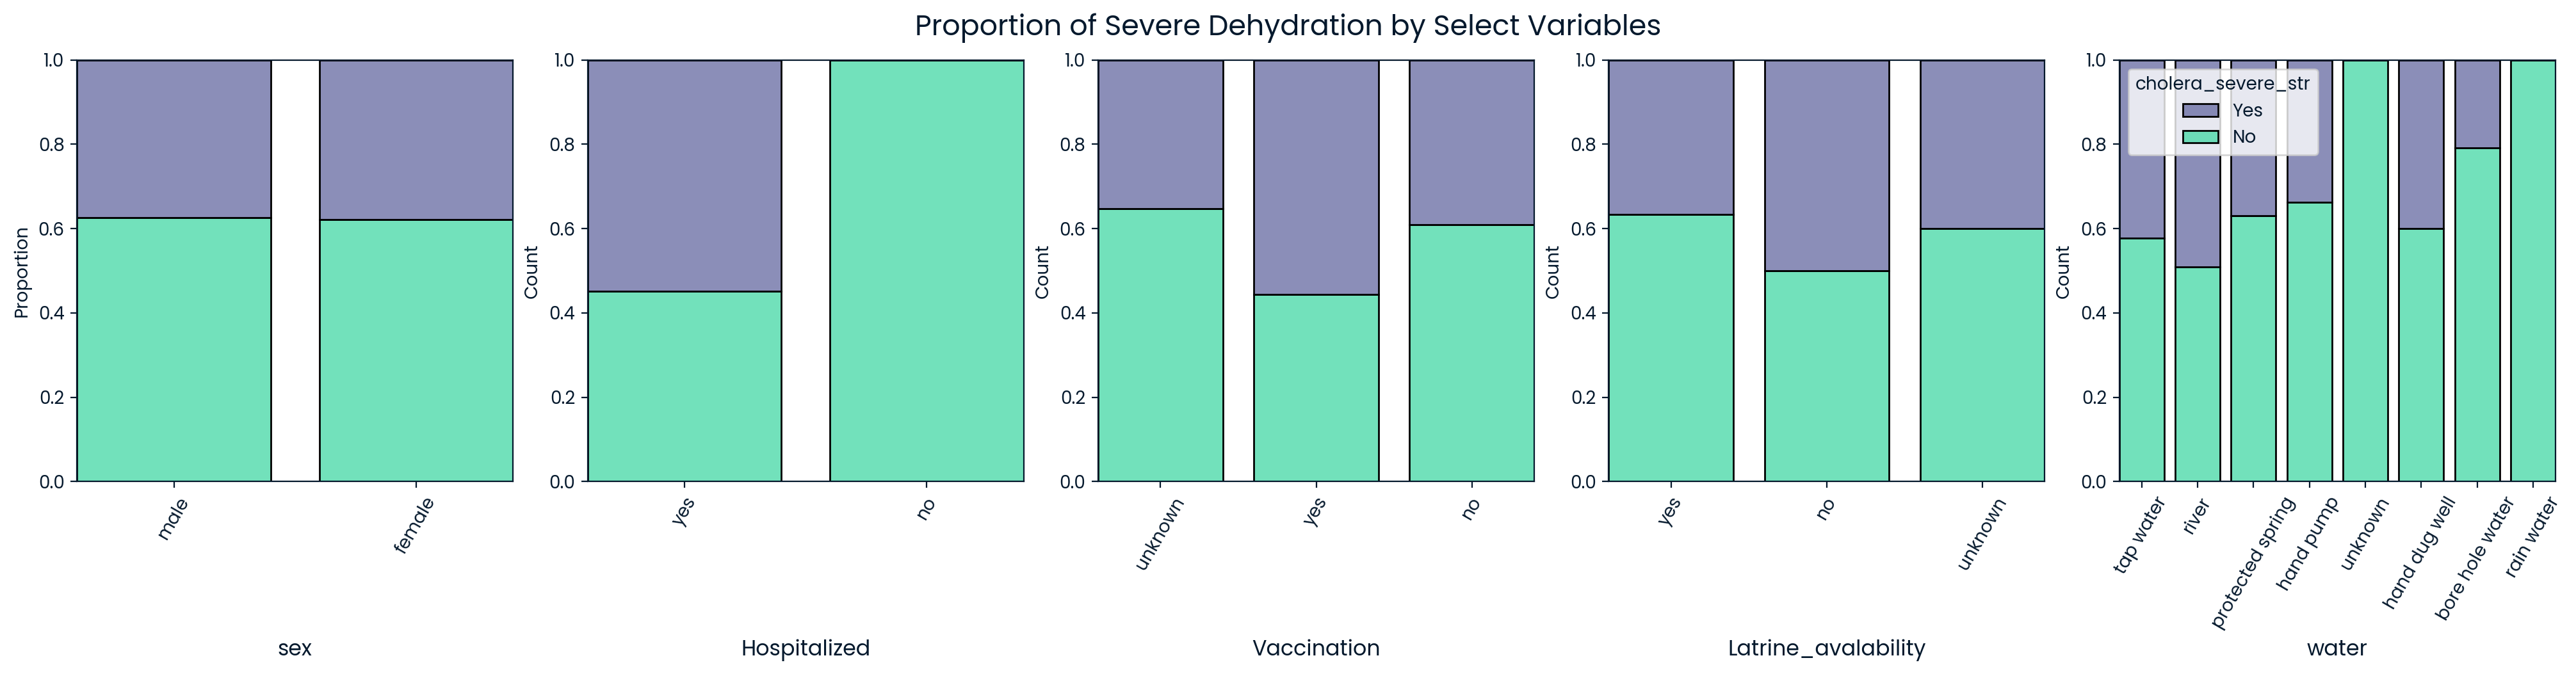

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()

# Step 1: Clean string categories (strip whitespace) for consistency
for col in ['sex', 'Hospitalized', 'Vaccination', 'Latrine_avalability', 'water']:
    df_cholera[col] = df_cholera[col].astype(str).str.lower().str.strip()

# Step 2: Map the binary target cholera_severe to string labels for plotting
df_cholera['cholera_severe_str'] = df_cholera['cholera_severe'].map({1: 'Yes', 0: 'No'})

# Step 3: Create subplots
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

# Step 4: Plot proportional histograms with hue = severe dehydration status
sns.histplot(df_cholera, x="sex", hue="cholera_severe_str", multiple="fill", shrink=0.8, ax=ax0, legend=False)
sns.histplot(df_cholera, x="Hospitalized", hue="cholera_severe_str", multiple="fill", shrink=0.8, ax=ax1, legend=False)
sns.histplot(df_cholera, x="Vaccination", hue="cholera_severe_str", multiple="fill", shrink=0.8, ax=ax2, legend=False)
sns.histplot(df_cholera, x="Latrine_avalability", hue="cholera_severe_str", multiple="fill", shrink=0.8, ax=ax3, legend=False)
sns.histplot(df_cholera, x="water", hue="cholera_severe_str", multiple="fill", shrink=0.8, ax=ax4)

# Step 5: Formatting axes
ax0.set_ylabel('Proportion')
axes = [ax0, ax1, ax2, ax3, ax4]
col_names = ['sex', 'Hospitalized', 'Vaccination', 'Latrine_avalability', 'water']

for ax, col in zip(axes, col_names):
    ax.set_xlabel('')  # Remove default x-label
    ax.tick_params(axis='x', rotation=60)
    # Add column name below x-ticks
    ax.annotate(
        col, 
        xy=(0.5, -0.4), 
        xycoords='axes fraction', 
        ha='center', 
        va='center', 
        fontsize=12
    )

# Step 6: Add a title and legend
fig.suptitle("Proportion of Severe Dehydration by Select Variables", fontsize=16)
handles, labels = ax4.get_legend_handles_labels()

plt.show()

The exploratory analysis of severe dehydration proportions across multiple patient and environmental factors reveals several notable patterns.


First, there is high portion of the population having non-severe cholera regardless of sex. 

Hospitalization status exhibits a marked association with severity; patients who were hospitalized show a substantially higher proportion of severe dehydration than those not admitted, underscoring clinical management alignment with disease severity. 

Cholera vaccination history presents an interesting pattern where individuals with a known history of vaccination have a comparatively elevated severe dehydration proportion relative to unvaccinated or unknown-status groups. This may point to complexities such as vaccine coverage, and timing relative to onset.

Similarly, availability of latrine facilities does not appear to confer a clear protective association based on severity proportions, as severe cases are distributed relatively evenly across categories of latrine presence or absence. Furthermore, high proportions of patients have non-severe cholera regardless of latrine availability.

Analysis of water source types reveal considerable heterogeneity in severe dehydration proportions. Patients relying on hand pumps, boreholes, and wells show higher severity proportions, whereas those using tap water or protected springs have relatively lower severe case proportions. This highlights the **potential role of water source quality** and associated contamination risks in influencing clinical severity.

Overall, these findings underline the multifactorial nature of cholera severity and the importance of integrating demographic, clinical, and environmental variables in comprehensive public health strategies.

In [8]:
df_cholera.columns

Index(['SerialNo', 'AgeYear', 'Kebelename', 'HealthFacilityCTC',
       'DateseenathealthfacilityM', 'DateofonsetofdiseaseMMD',
       'DiagnosticTestResultPositiv', 'IfYeswhere', 'EpiweekDateofonset',
       'MonthDateofonset', 'YearDateofonset', 'Dischargedate',
       'CurrentaddmisionstatusAdmitt', 'sex', 'Region', 'Zone', 'District',
       'Hospitalized', 'specimen_taken', 'type_diagnosis',
       'Dehaydration_status', 'Disinfection', 'Wattery_Diarrhea', 'Vomiting',
       'Occupation', 'water', 'Water_source', 'Contact_history',
       'Travel_history', 'cases_from', 'outcome', 'outcom', 'Vaccination',
       'Latrine_avalability', 'Age_category', 'symptom', 'diarrhoea', 'vomit',
       'cholera_severe', 'cholera_severe_str'],
      dtype='object')

### Spatial Visualization of Cholera Cases and Environmental Features in Gedeo Zone


I this sectio, I performed geospatial visualization integrating cholera case data, administrative boundaries, and key environmental features within the Gedeo Zone. By mapping the spatial distribution of cholera cases alongside natural and administrative landmarks, this analysis aims to uncover potential geographic patterns and environmental correlations that may influence disease dynamics.

The approach begins with retrieving precision administrative boundary data for the Gedeo Zone using the OpenStreetMap Overpass API. These boundaries provide the geographical context within which the epidemiological data are analyzed. To enhance spatial accuracy, a buffered region surrounding the boundaries is defined, ensuring that proximate features of interest are included without extraneous map elements.

Next, I queried and mapped waterways (e.g., rivers, streams, and drainage paths) within or near the Gedeo Zone. Water bodies are essential environmental variables in cholera epidemiology, as they can serve as reservoirs or transmission vectors. The waterway geometries are simplified and smoothed using spline interpolation to provide visually coherent river paths on the map.

Cholera case data, aggregated spatially (e.g., at kebele or community centroids), are overlaid on this geographic backdrop. Cases are represented as colored circles, where the color intensity corresponds to the number of reported cases, and the marker size reflects population magnitude, facilitating simultaneous comprehension of disease burden and demographic scale. This multivariate marker design aids in identifying high-risk areas that may warrant targeted public health interventions.

Finally, the visualization incorporates well-designed legends and annotations to improve interpretability, including clear differentiation of administrative boundaries, waterways, cholera cases, and population size references. The resulting map facilitates an integrated spatial understanding of cholera distribution relative to environmental and administrative constructs, providing a valuable tool for epidemiological insight and resource planning.


In [9]:
!pip install osmnx geopandas matplotlib contextily pandas
!pip install OSMPythonTools



<Figure size 640x480 with 0 Axes>

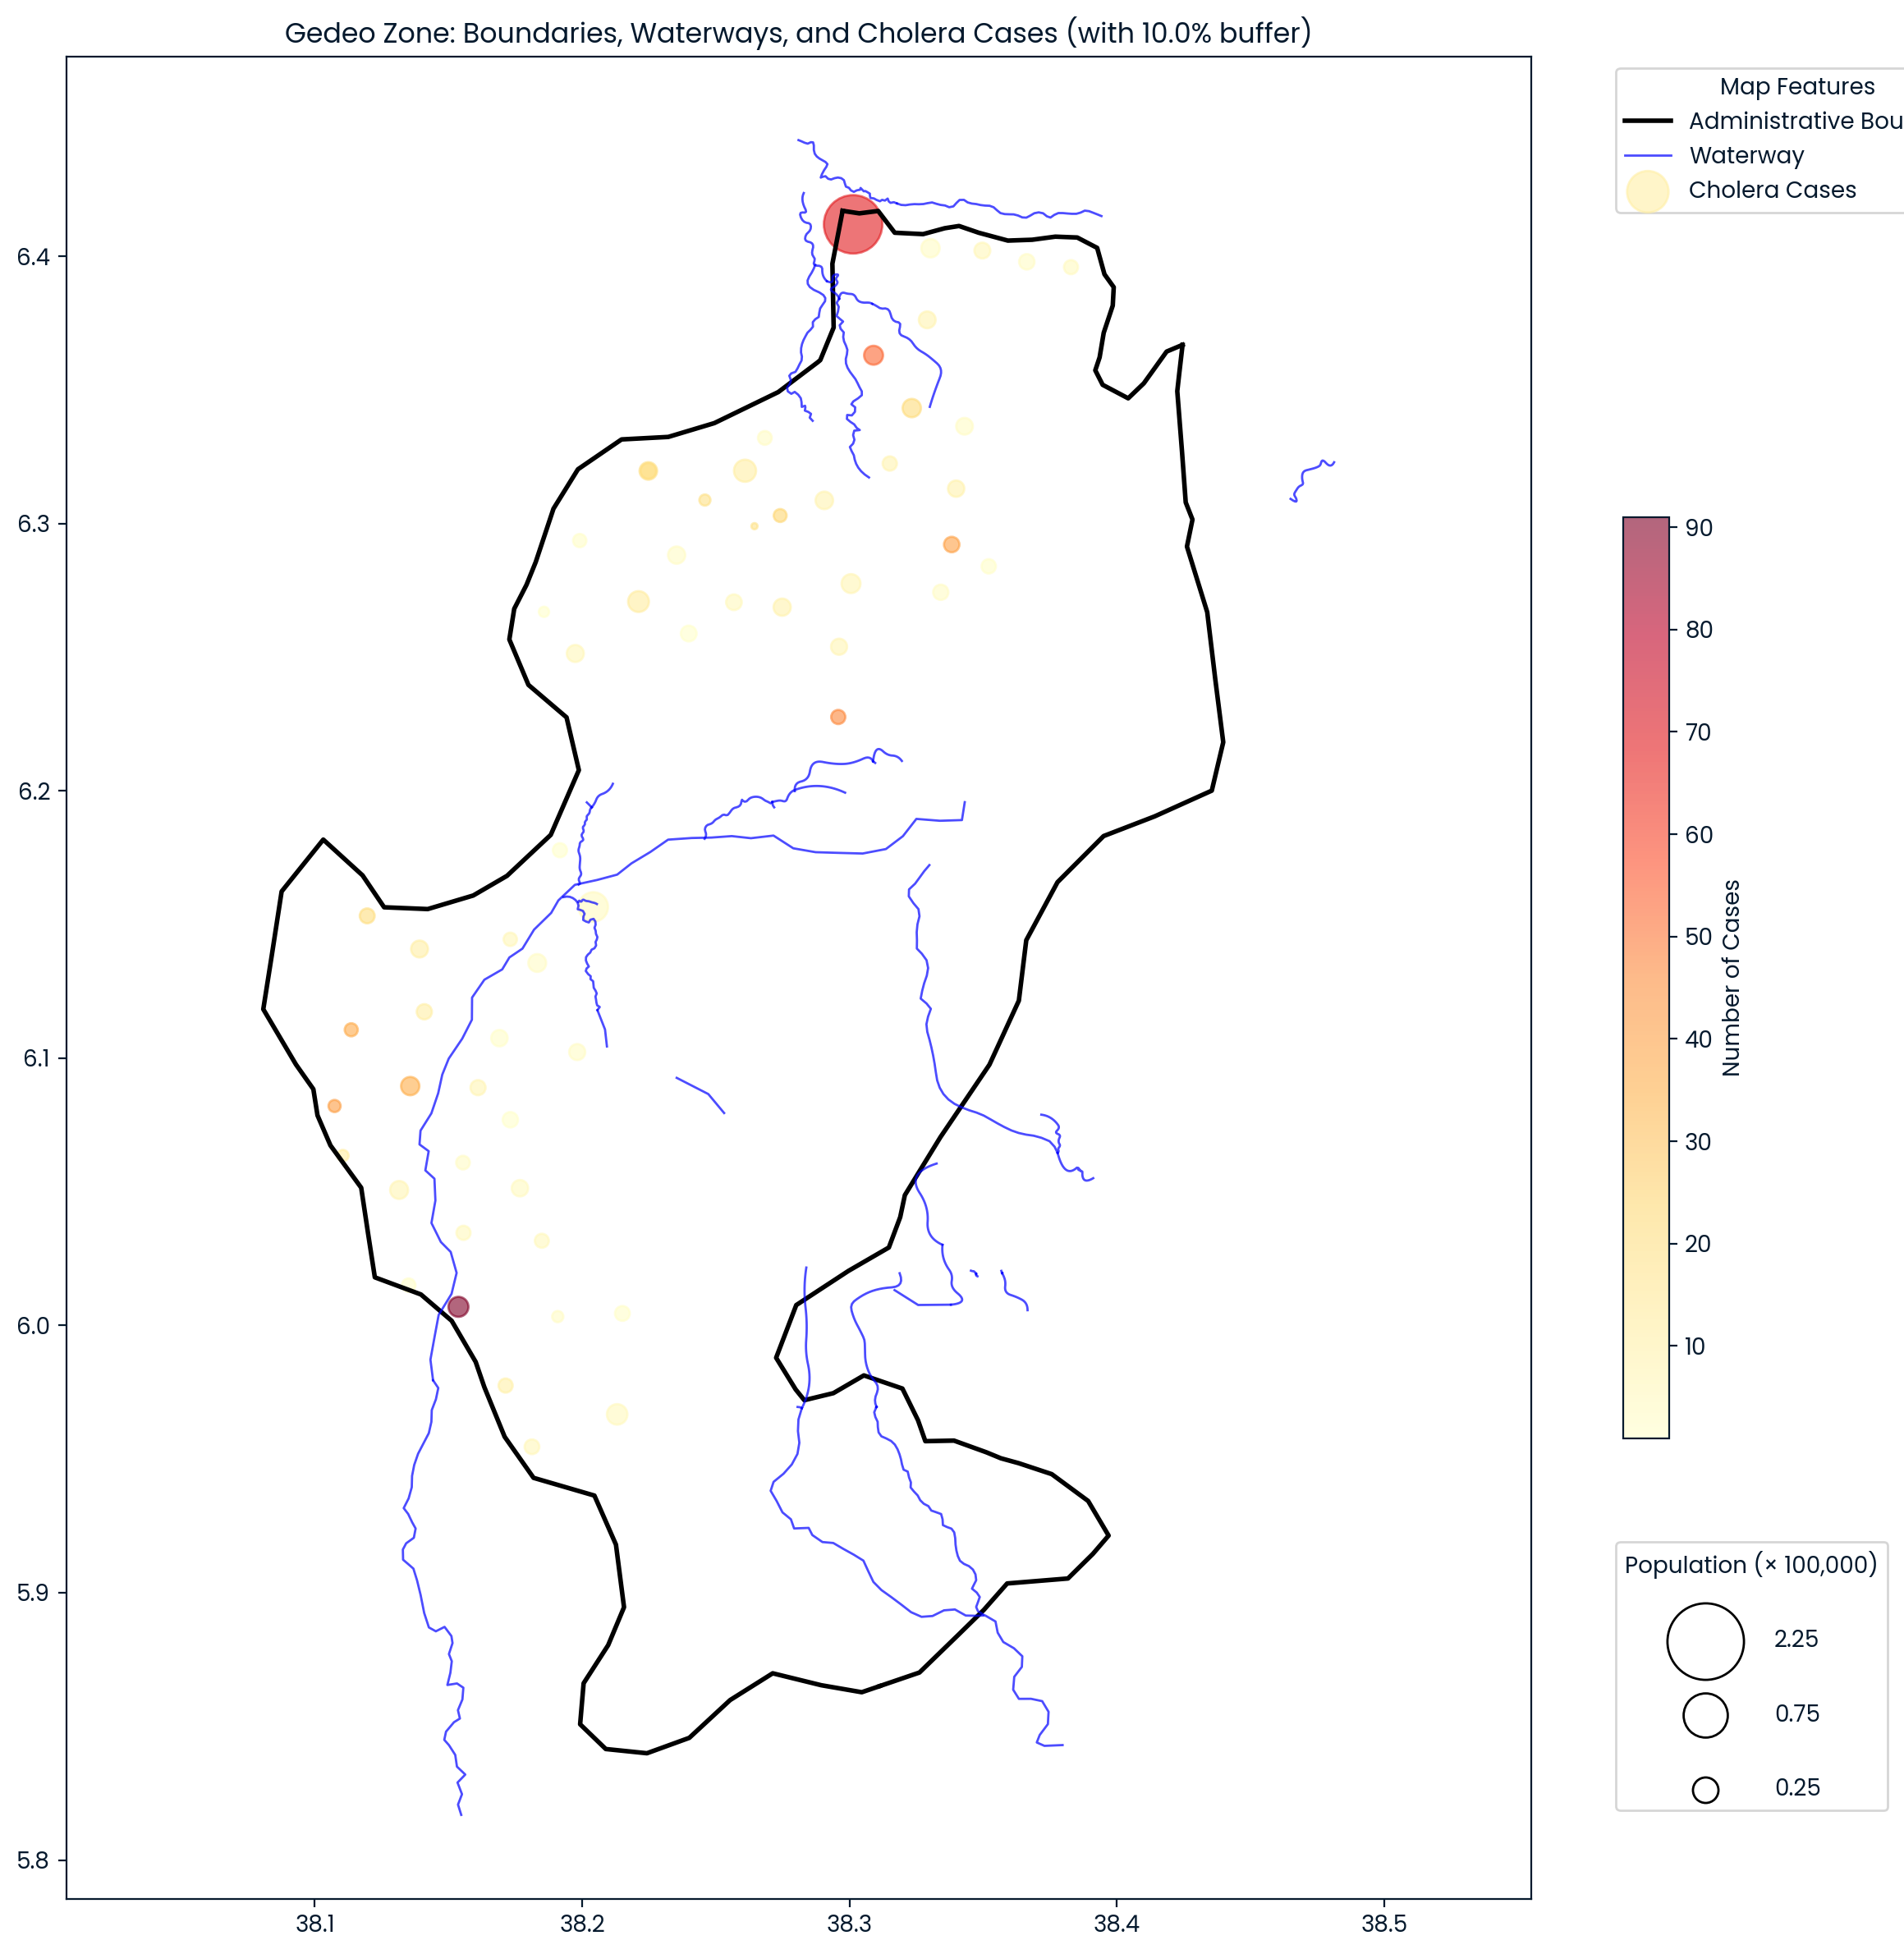

In [10]:
# ===============================
# Spatial Visualization of Gedeo Zone Cholera Cases, Boundaries, and Waterways
# ===============================

df = df_gis.copy() # use CHOLERA2 for cholera cases

# --- Import other required libraries ---
from OSMPythonTools.overpass import Overpass
from scipy.interpolate import splprep, splev
from matplotlib.path import Path

# --- Configuration Parameters ---
BUFFER_FRACTION = 0.1          # Buffer zone size around administrative boundaries (10%)
POPULATION_MULTIPLIER = 500    # Scaling factor for circle sizes representing population

# --- Initialize Plot ---
plt.clf()
plt.figure(figsize=(12, 12))

# --- Section 1: Retrieve and Plot Administrative Boundaries ---

# Initialize Overpass API instance
overpass = Overpass()

# Query Gedeo Zone administrative boundary relation and all associated ways and nodes
gedeo = overpass.query('relation(3306767);(._;>;);out body;')

boundary_coords = []  # Store coordinates of all administrative boundary ways

# Loop through elements to extract administrative boundary ways
for element in gedeo.elements():
    if element.type() == 'way' and element.tags().get('boundary') == 'administrative':
        
        # Extract list of [longitude, latitude] coordinate pairs for each boundary way
        coords = [[node.geometry()['coordinates'][0], node.geometry()['coordinates'][1]] 
                  for node in element.nodes()]
        
        if coords:
            boundary_coords.append(coords)
            
            # Unpack x and y to plot boundary lines
            x, y = zip(*coords)
            plt.plot(x, y, 'k-', linewidth=2, label='Administrative Boundary')

# Concatenate all boundary points for spatial calculations
boundary_points = np.vstack(boundary_coords)

# Create a path object from boundary points to test point inclusion later
boundary_path = Path(boundary_points)

# Calculate spatial extent and buffer distance for clipping features near the boundary
min_x, min_y = np.min(boundary_points, axis=0)
max_x, max_y = np.max(boundary_points, axis=0)
dx, dy = max_x - min_x, max_y - min_y
buffer_distance = max(dx, dy) * BUFFER_FRACTION

# --- Section 2: Query and Plot Waterways within or near Gedeo Zone ---

# Overpass API query to retrieve all waterways in bounding box covering Gedeo Zone
waterways_query = """
way["waterway"](5.85,38,6.42,38.5);
(._;>;);
out body;
"""
gedeo_waterways = overpass.query(waterways_query)

# Loop through waterway ways to extract nodes and plot smoothed waterway lines
for element in gedeo_waterways.elements():
    if element.type() == 'way' and element.tags().get('waterway'):
        nodes = element.nodes()
        
        # Subsample nodes to roughly 20% for performance and smoother curves (min 3 points)
        n_points = min(max(3, len(nodes)//5), len(nodes))
        indices = np.linspace(0, len(nodes)-1, n_points, dtype=int)
        key_points = [nodes[i] for i in indices]
        
        points = []
        # Filter points to those inside the boundary or within buffer distance
        for node in key_points:
            point = np.array([node.geometry()['coordinates'][0], node.geometry()['coordinates'][1]])
            
            # Check if point is inside administrative boundary polygon
            if boundary_path.contains_points([point])[0]:
                points.append(point)
            else:
                # Calculate minimum distance from point to boundary points
                distances = np.sqrt(np.sum((boundary_points - point)**2, axis=1))
                
                # Include point if it lies within the buffer distance around boundary
                if np.min(distances) <= buffer_distance:
                    points.append(point)
        
        # Plot smooth curve for waterway if sufficient points exist
        if len(points) > 1:
            points = np.array(points)
            x, y = points[:, 0], points[:, 1]
            
            if len(x) > 3:
                # Use spline interpolation to smooth the line
                tck, u = splprep([x, y], s=0, k=2)
                unew = np.linspace(0, 1, 50)
                smooth_x, smooth_y = splev(unew, tck)
                plt.plot(smooth_x, smooth_y, 'b-', linewidth=1, alpha=0.7)
            else:
                # Plot straight line if fewer points for smoothing
                plt.plot(x, y, 'b-', linewidth=1, alpha=0.7)

# Add a dummy plot line for waterway legend
plt.plot([], [], 'b-', linewidth=1, alpha=0.7, label='Waterway')

# --- Section 3: Plot Cholera Cases as Circle Markers ---

# 'df' must be a DataFrame with columns 'Longitude', 'Latitude', 'Cases', and 'Population'
# Scatter size scales with Population and color intensity corresponds to number of cholera cases
scatter = plt.scatter(
    df['Longitude'], 
    df['Latitude'], 
    c=df['Cases'],
    s=(df['Population'] / 100000) * POPULATION_MULTIPLIER,
    cmap='YlOrRd',
    alpha=0.6,
    label='Cholera Cases'
)

# Add a colorbar to indicate the scale of number of cases
cbar = plt.colorbar(scatter, label='Number of Cases', shrink=0.5)

# --- Section 4: Final Formatting and Legend Handling ---

plt.title(f'Gedeo Zone: Boundaries, Waterways, and Cholera Cases (with {BUFFER_FRACTION*100}% buffer)')
plt.axis('equal')  # Equal aspect ratio for latitude/longitude

# Extract unique legend entries and create a consolidated legend for map features
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
map_legend = plt.legend(
    unique_labels.values(), 
    unique_labels.keys(),
    title='Map Features',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.gca().add_artist(map_legend)

# --- Section 5: Add Population Size Reference Circles Legend ---

# Create invisible scatter points for population legend/reference sizes
population_elements = [
    plt.scatter([], [], c='white', edgecolor='black', s=2.25 * POPULATION_MULTIPLIER, label='2.25'),
    plt.scatter([], [], c='white', edgecolor='black', s=0.75 * POPULATION_MULTIPLIER, label='0.75'),
    plt.scatter([], [], c='white', edgecolor='black', s=0.25 * POPULATION_MULTIPLIER, label='0.25')
]

# Add legend explaining circle sizes relate to population (per 100,000)
plt.legend(
    population_elements, 
    ['2.25', '0.75', '0.25'],
    title='Population (× 100,000)',
    bbox_to_anchor=(1.05, 0.2),
    loc='upper left',
    labelspacing=2.25, 
    handletextpad=2
)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('results/gedeo_cholera_map.png', dpi=300, bbox_inches='tight')
plt.show()


### Results and discussion

The objective of this spatial analysis is to identify geographic pockets or clusters where cholera incidence tends to be elevated within the Gedeo Zone. By overlaying reported cholera cases with waterways and administrative boundaries, we aim to detect spatial patterns and hotspots that could reveal key environmental drivers or transmission corridors. Such insights are critical for targeting public health interventions effectively.

**Key Observations**

_**Spatial Distribution Patterns**_

- Cholera cases frequently cluster along or near waterways, particularly evident in the central and northern parts of the study area. This observation aligns with the well-established epidemiological knowledge that cholera transmission commonly occurs via contaminated water sources.

_**Notable Clusters**_

- **Northern Cluster (around 6.4°N):**  
  This area exhibits a high concentration of cases with moderate intensity (orange-red shading), located adjacent to multiple waterway intersections. Such a location may facilitate the spread of cholera through converging water sources.

- **Central Cluster (around 6.2–6.3°N):**  
  Several smaller clusters are distributed here, showing moderate case numbers (yellow-orange shading). These clusters are positioned between several water channels, suggesting a localized risk environment related to water infrastructure.

- **Southern Hotspot (around 6.0°N):**  
  This region features a large and intense cluster of cases (dark red), precisely where a waterway crosses the administrative boundary. This spatial configuration indicates a potential cross-boundary transmission risk, emphasizing the need for coordinated regional surveillance.

**Technical and Mapping Insights**

- The buffered waterways, created using a 10% buffer around administrative boundaries, successfully highlight potential zones of water influence on disease spread.  
- Circle sizes graduated by population effectively convey demographic scale alongside case counts.  
- The applied color gradient (YlOrRd colormap) clearly differentiates case intensity, enhancing visual interpretation.

**Geographic Context Considerations**

- Administrative boundaries provide a definitive spatial framework for the analysis, anchoring cholera incidence within relevant governance areas.  
- The waterway network illustrates probable transmission pathways, supporting classical environmental transmission models.  
- The chosen spatial scale allows examination of both broad regional trends and localized hotspot patterns.

**Epidemiological Implications**

- These spatial patterns support the classical model of cholera transmission driven by waterways, highlighting upstream-downstream dynamics.  
- Waterway junctions emerge as critical nodes associated with elevated case numbers, suggesting focal points for monitoring and intervention.  
- Cross-border waterways may facilitate interregional spread, raising the importance of cooperative public health strategies across administrative areas.  
- Settlement proximity to key water sources reinforces the environmental risk context underpinning cholera outbreaks.

**Application for Public Health Interventions**

This spatial analysis provides actionable insights for public health interventions by identifying priority zones for enhanced water quality monitoring and sanitation improvements. It informs the strategic placement of cholera treatment facilities aligned with high-risk clusters and encourages cross-boundary collaboration in disease surveillance, particularly near waterways crossing administrative borders. Additionally, it supports targeted implementation of WASH (Water, Sanitation, and Hygiene) programs and facilitates data-driven resource allocation and community risk communication through clear, evidence-based mapping.

In the subsequent notebook, a machine learning approach employing an XGBoost-based classifier will be developed to predict cholera severity, offering a potentially valuable tool to assist healthcare practitioners in risk stratification and resource prioritization. Should you have questions about this notebook, feel free to reach out to me at jprmaulion[at]gmail[dot]com.